In [1]:
# Python core
from typing import Optional, Callable, TypedDict, Union, Iterable, Tuple, NamedTuple, List
from dataclasses import dataclass
import datetime
from itertools import product
from concurrent import futures

# Scientific python
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# PyTorch
# import torch
# from torch import nn
# import torch.nn.functional as F
# from torchvision import transforms
# import pytorch_lightning as pl

In [2]:
import bokeh
print('bokeh version: ', bokeh.__version__)

bokeh version:  3.2.1


In [ ]:
# if 'client' in locals():
#     client.shutdown()
#     print('...shutdown client...')
# else:
#     print('client does not exist yet')

2023-12-06 15:24:40,772 - tornado.application - ERROR - Exception in callback <bound method ActiveMemoryManagerExtension.run_once of <distributed.active_memory_manager.ActiveMemoryManagerExtension object at 0x14f4359027d0>>
Traceback (most recent call last):
  File "/glade/work/wchapman/miniconda3.1/envs/MLWPS/lib/python3.11/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
          ^^^^^^^^^^^^^^^
  File "/glade/work/wchapman/miniconda3.1/envs/MLWPS/lib/python3.11/site-packages/distributed/utils.py", line 760, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/glade/work/wchapman/miniconda3.1/envs/MLWPS/lib/python3.11/site-packages/distributed/active_memory_manager.py", line 176, in run_once
    self._enact_suggestions()
  File "/glade/work/wchapman/miniconda3.1/envs/MLWPS/lib/python3.11/site-packages/distributed/active_memory_manager.py", line 421, in _enact_suggestions
    self.scheduler.request_remove_replicas(
  File 

In [4]:
from distributed import Client
from dask_jobqueue import PBSCluster

cluster = PBSCluster(account='NAML0001',walltime='12:00:00',cores=1, memory='100GB',shared_temp_directory='/glade/scratch/wchapman/tmp',queue='main')
cluster.scale(jobs=40)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.14.13.193:8787/status,
Dashboard: http://10.14.13.193:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.14.13.193:39741,Workers: 0
Dashboard: http://10.14.13.193:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Load the Zarr file

In [5]:
%%time
ZARR = '/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/TOTAL_2010-01-01_2010-12-31_staged.zarr'

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['image.interpolation'] = 'none'

def get_forward_data(filename: str=ZARR) -> xr.DataArray:
    """Lazily opens the Zarr store on gladefilesystem.
    """
    dataset = xr.open_zarr(filename, consolidated=True)
    return dataset

forcing_data = get_forward_data().unify_chunks()
forcing_data

CPU times: user 10.6 s, sys: 815 ms, total: 11.4 s
Wall time: 26.2 s


<xarray.Dataset>
Dimensions:     (time: 8760, level: 15, latitude: 640, longitude: 1280,
                 half_level: 138)
Coordinates:
  * half_level  (half_level) int32 1 2 3 4 5 6 7 ... 132 133 134 135 136 137 138
  * latitude    (latitude) float64 89.78 89.51 89.23 ... -89.23 -89.51 -89.78
  * level       (level) int32 10 30 40 50 60 70 80 90 95 100 105 110 120 130 136
  * longitude   (longitude) float64 0.0 0.2812 0.5625 ... 359.2 359.4 359.7
  * time        (time) datetime64[ns] 2010-01-01 ... 2010-12-31T23:00:00
Data variables:
    Q           (time, level, latitude, longitude) float32 dask.array<chunksize=(10, 4, 139, 277), meta=np.ndarray>
    Q500        (time, latitude, longitude) float32 dask.array<chunksize=(10, 139, 277), meta=np.ndarray>
    SP          (time, latitude, longitude) float32 dask.array<chunksize=(10, 139, 277), meta=np.ndarray>
    T           (time, level, latitude, longitude) float32 dask.array<chunksize=(10, 4, 139, 277), meta=np.ndarray>
    T500        (time, latitude, longitude) float32 dask.array<chunksize=(10, 139, 277), meta=np.ndarray>
    U           (time, level, latitude, longitude) float32 dask.array<chunksize=(10, 4, 139, 277), meta=np.ndarray>
    U500        (time, latitude, longitude) float32 dask.array<chunksize=(10, 139, 277), meta=np.ndarray>
    V           (time, level, latitude, longitude) float32 dask.array<chunksize=(10, 4, 139, 277), meta=np.ndarray>
    V500        (time, latitude, longitude) float32 dask.array<chunksize=(10, 139, 277), meta=np.ndarray>
    Z500        (time, latitude, longitude) float32 dask.array<chunksize=(10, 139, 277), meta=np.ndarray>
    t2m         (time, latitude, longitude) float32 dask.array<chunksize=(10, 139, 277), meta=np.ndarray>

## Create the Tendency 

In [22]:
#open the normalization dictionary:

DSm = xr.open_dataset('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/All_2010_staged.mean.Lev.SLO.nc')
DSs = xr.open_dataset('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/All_2010_staged.std.Lev.SLO.nc')

#normalize the forcing:
forcing_data_scaled=(forcing_data-DSm)/DSs

In [23]:
varlist = ['U','V','T','Q','t2m','SP','Q500','Z500','T500','V500','U500']

for vardo in varlist: 
    forcing_data_diff = forcing_data_scaled[vardo].diff('time').to_dataset(name=vardo)
    print('diff done')
    if vardo in ['U','V','T','Q']:
        Mean_latlonlev = forcing_data_diff.mean(['time','latitude','longitude','level']).persist()
    else:
        Mean_latlonlev = forcing_data_diff.mean(['time','latitude','longitude']).persist()
    print('...moving on to load...')
    Mean_latlonlev = Mean_latlonlev.load()
    print('...mean done...')
    print('...saving...')
    Mean_latlonlev.to_netcdf(f'/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/All_NORMtend_{vardo}_2010_staged.mean.nc')
    del forcing_data_diff

diff done


/glade/work/wchapman/miniconda3.1/envs/MLWPS/lib/python3.11/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 213.51 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


...moving on to load...



KeyboardInterrupt



In [ ]:
varlist = ['U','V','T','Q','t2m','SP','Q500','Z500','T500','V500','U500']

for vardo in varlist: 
    forcing_data_diff = forcing_data_scaled[vardo].diff('time').to_dataset(name=vardo)
    print('diff done')
    if vardo in ['U','V','T','Q']:
        STD_latlonlev = forcing_data_diff.std(['time','latitude','longitude']).persist()
    else:
        STD_latlonlev = forcing_data_diff.std(['time','latitude','longitude']).persist()
    print('...moving on to load...')
    STD_latlonlev = STD_latlonlev.load()
    print('...STD done...')
    print('...saving...')
    STD_latlonlev.to_netcdf(f'/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/All_NORMtend_{vardo}_2010_staged.STD.nc')
    del forcing_data_diff

## Difference in Time Forcing Data

In [7]:
varlist = ['U','V','T','t2m','SP','Q500','Z500','T500','V500','U500']
varlist = ['Q']

for vardo in varlist: 
    forcing_data_diff = forcing_data[vardo].diff('time').to_dataset(name=vardo)
    forcing_data_diff
    print('diff done')
    if vardo in ['U','V','T','Q']:
        Mean_latlonlev = forcing_data_diff.mean(['time','latitude','longitude','level']).persist()
    else:
        Mean_latlonlev = forcing_data_diff.mean(['time','latitude','longitude']).persist()
    print('...moving on to load...')
    Mean_latlonlev = Mean_latlonlev.load()
    print('...mean done...')
    print('...saving...')
    Mean_latlonlev.to_netcdf(f'/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/All_diff_{vardo}_2010_staged.mean.nc')
    del forcing_data_diff

diff done


/glade/work/wchapman/miniconda3.1/envs/MLWPS/lib/python3.11/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 197.81 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


...moving on to load...
...mean done...
...saving...


In [8]:
varlist = ['U','V','T','Q','t2m','SP','Q500','Z500','T500','V500','U500']
varlist = ['Q']

for vardo in varlist: 
    forcing_data_diff = forcing_data[vardo].diff('time').to_dataset(name=vardo)
    forcing_data_diff
    print('diff done')
    if vardo in ['U','V','T','Q']:
        STD_latlonlev = forcing_data_diff.std(['time','latitude','longitude']).persist()
    else:
        STD_latlonlev = forcing_data_diff.std(['time','latitude','longitude']).persist()
    print('...moving on to load...')
    STD_latlonlev = STD_latlonlev.load()
    print('...STD done...')
    print('...saving...')
    STD_latlonlev.to_netcdf(f'/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/All_diff_{vardo}_2010_staged.STD.nc')
    del forcing_data_diff

diff done


/glade/work/wchapman/miniconda3.1/envs/MLWPS/lib/python3.11/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 199.04 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


...moving on to load...
...STD done...
...saving...


In [10]:
Mean_latlonlev = forcing_data_diff.mean(['time','latitude','longitude','level']).persist()
print('...moving on to load...')
Mean_latlonlev = Mean_latlonlev.load()
print('...mean done...')
print('...saving...')
Mean_latlonlev.to_netcdf('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/All_diff_2010_staged.mean.nc')


In [ ]:
STD_latlonlev = forcing_data_diff.std(['time','latitude','longitude','level']).persist()
print('...moving on to load...')
STD_latlonlev = STD_latlonlev.load()
print('...mean done...')
print('...saving...')
STD_latlonlev.to_netcdf('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/All_diff_2010_staged.STD.nc')

In [ ]:
Mean_latlonlev = forcing_data_diff.mean(['time','latitude','longitude']).persist()
print('...moving on to load...')
Mean_latlonlev = Mean_latlonlev.load()
print('...mean done...')
print('...saving...')
Mean_latlonlev.to_netcdf('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/All_diff_2010_staged.SL.mean.nc')


In [ ]:
STD_latlonlev = forcing_data_diff.std(['time','latitude','longitude']).persist()
print('...moving on to load...')
STD_latlonlev = STD_latlonlev.load()
print('...mean done...')
print('...saving...')
STD_latlonlev.to_netcdf('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/All_diff_2010_staged.SL.STD.nc')


In [ ]:
Mean_latlonlev = forcing_data_diff.mean(['time']).persist()
print('...moving on to load...')
Mean_latlonlev = Mean_latlonlev.load()
print('...mean done...')
print('...saving...')
Mean_latlonlev.to_netcdf('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/All_diff_2010_staged.T.SL.mean.nc')


In [ ]:
STD_latlonlev = forcing_data_diff.std(['time']).persist()
print('...moving on to load...')
STD_latlonlev = STD_latlonlev.load()
print('...mean done...')
print('...saving...')
STD_latlonlev.to_netcdf('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/All_diff_2010_staged.T.SL.STD.nc')


## Take a Variety of Means/STDs and Save them
- you need a massive amount of compute to do this; try it in the morning before every other NCAR employee wakes up 

In [5]:
%%time
Mean_latlonlev = forcing_data.mean(['time','latitude','longitude','level']).persist()
print('...moving on to load...')
Mean_latlonlev = Mean_latlonlev.load()
print('...mean done...')
print('...saving...')
Mean_latlonlev.to_netcdf('/glade/derecho/scratch/wchapman/STAGING/All_2010_staged.mean.nc')


In [6]:
STD_latlonlev = forcing_data.std(['time','latitude','longitude','level']).persist()
# print('...moving on to load...')
STD_latlonlev = STD_latlonlev.load()
print('...saving...')
STD_latlonlev.to_netcdf('/glade/derecho/scratch/wchapman/STAGING/All_2010_staged.std.nc')

## Add A New Variable:

In [7]:
%%time
ZARR = '/glade/derecho/scratch/wchapman/STAGING/t2m_2010-01-01_2011-01-01_staged.zarr'

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['image.interpolation'] = 'none'

def get_forward_data(filename: str=ZARR) -> xr.DataArray:
    """Lazily opens the Zarr store on gladefilesystem.
    """
    dataset = xr.open_zarr(filename, consolidated=True)
    return dataset

forcing_data = get_forward_data().unify_chunks()
forcing_data

CPU times: user 643 ms, sys: 179 ms, total: 822 ms
Wall time: 4.56 s


<xarray.Dataset>
Dimensions:    (latitude: 640, longitude: 1280, time: 9504)
Coordinates:
  * latitude   (latitude) float64 89.78 89.51 89.23 ... -89.23 -89.51 -89.78
  * longitude  (longitude) float64 0.0 0.2812 0.5625 ... 359.2 359.4 359.7
  * time       (time) datetime64[ns] 2010-01-01 ... 2011-01-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(10, 139, 277), meta=np.ndarray>

In [8]:
%%time
Mean_latlonlev = forcing_data.mean(['time','latitude','longitude']).persist()
print('...moving on to load...')
Mean_latlonlev = Mean_latlonlev.load()
print('...mean done...')
print('...saving...')
# Mean_latlonlev.to_netcdf('/glade/derecho/scratch/wchapman/STAGING/All_2010_staged.mean.nc')
DSold = xr.open_dataset('/glade/derecho/scratch/wchapman/STAGING/All_2010_staged.SL.mean.nc')
DSold = xr.merge([DSold,Mean_latlonlev]).to_netcdf('/glade/derecho/scratch/wchapman/STAGING/All_2010_staged.SL.mean.nc')
print('done')

...moving on to load...
...mean done...
...saving...
CPU times: user 19.8 s, sys: 1.1 s, total: 20.9 s
Wall time: 39.3 s


In [15]:
%%time
STD_latlonlev = forcing_data.std(['time','latitude','longitude']).persist()
print('...moving on to load...')
STD_latlonlev = STD_latlonlev.load()
print('...mean done...')
print('...saving...')
# Mean_latlonlev.to_netcdf('/glade/derecho/scratch/wchapman/STAGING/All_2010_staged.mean.nc')
DSold = xr.open_dataset('/glade/derecho/scratch/wchapman/STAGING/All_2010_staged.SL.std.nc')
DSold = xr.merge([DSold,STD_latlonlev]).to_netcdf('/glade/derecho/scratch/wchapman/STAGING/All_2010_staged.SL.std.nc')
print('done')

...moving on to load...
...mean done...
...saving...
done
CPU times: user 19.9 s, sys: 1.19 s, total: 21.1 s
Wall time: 25.8 s


In [26]:
varsdo = ['t2m','T500','U500','Q500','V500','Z500']
DSold = xr.open_dataset('/glade/derecho/scratch/wchapman/STAGING/All_2010_staged.mean.Lev.nc')
DSoldstd = xr.open_dataset('/glade/derecho/scratch/wchapman/STAGING/All_2010_staged.std.Lev.nc')

for ee,varsy in enumerate(varsdo):
    ZARR = '/glade/derecho/scratch/wchapman/STAGING/'+varsy+'_2010-01-01_2011-01-01_staged.zarr'

    plt.rcParams['figure.figsize'] = (5, 5)
    plt.rcParams['image.interpolation'] = 'none'

    def get_forward_data(filename: str=ZARR) -> xr.DataArray:
        """Lazily opens the Zarr store on gladefilesystem.
        """
        dataset = xr.open_zarr(filename, consolidated=True)
        return dataset

    forcing_data = get_forward_data().unify_chunks()
    forcing_data
    
    Mean_latlonlev = forcing_data.mean(['time','latitude','longitude']).persist()
    print('...moving on to load...')
    Mean_latlonlev = Mean_latlonlev.load()
    print('...mean done...')
    print('...saving...')
    DSold = xr.merge([DSold,Mean_latlonlev])
    print('done')
    
    STD_latlonlev = forcing_data.std(['time','latitude','longitude']).persist()
    print('...moving on to load...')
    STD_latlonlev = STD_latlonlev.load()
    print('...mean done...')
    print('...saving...')
    DSoldstd = xr.merge([DSoldstd,STD_latlonlev])
    print('done')

DSoldstd.to_netcdf('/glade/derecho/scratch/wchapman/STAGING/All_2010_staged.std.Lev.SLO.nc')
DSold.to_netcdf('/glade/derecho/scratch/wchapman/STAGING/All_2010_staged.mean.Lev.SLO.nc')


...moving on to load...
...mean done...
...saving...
done
...moving on to load...
...mean done...
...saving...
done
...moving on to load...
...mean done...
...saving...
done
...moving on to load...
...mean done...
...saving...
done
...moving on to load...
...mean done...
...saving...
done
...moving on to load...
...mean done...
...saving...
done
...moving on to load...
...mean done...
...saving...
done
...moving on to load...
...mean done...
...saving...
done
...moving on to load...
...mean done...
...saving...
done
...moving on to load...
...mean done...
...saving...
done
...moving on to load...
...mean done...
...saving...
done
...moving on to load...
...mean done...
...saving...
done


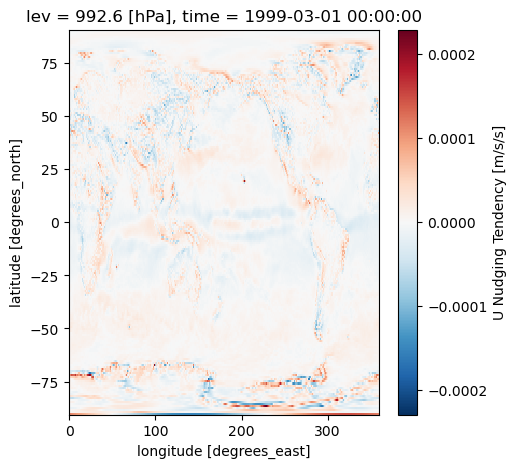

In [41]:
DSS = xr.open_dataset('/glade/scratch/wchapman/f.e21.FHIST_BGC.f09_f09_mg17.CFMIP-hadisst-vf_nudged/run/f.e21.FHIST_BGC.f09_f09_mg17.CFMIP-hadisst-vf_nudged.cam.h0.1999-02.nc')
DSS['Nudge_U'].squeeze().sel(lev=1000,method='nearest').plot()
plt.show()

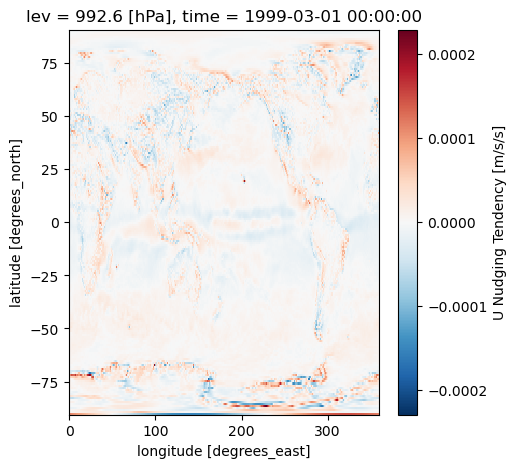

In [39]:
DSS['Nudge_U'].squeeze().sel(lev=1000,method='nearest').plot()

In [32]:
ls /glade/scratch/wchapman/f.e21.FHIST_BGC.f09_f09_mg17.CFMIP-hadisst-vf_nudged/run/

atm_in
atm.log.4273427.chadmin1.ib0.cheyenne.ucar.edu.231127-062735
atm_modelio.nml
CASEROOT
cesm.log.4273427.chadmin1.ib0.cheyenne.ucar.edu.231127-062735
cism.config
cism_in
cpl.log.4273427.chadmin1.ib0.cheyenne.ucar.edu.231127-062735
cpl_modelio.nml
docn_in
docn.streams.txt.prescribed
drv_flds_in
drv_in
esp_modelio.nml
f.e21.FHIST_BGC.f09_f09_mg17.CFMIP-hadisst-vf_nudged.cam.h0.1999-01.nc
f.e21.FHIST_BGC.f09_f09_mg17.CFMIP-hadisst-vf_nudged.cam.h0.1999-02.nc
f.e21.FHIST_BGC.f09_f09_mg17.CFMIP-hadisst-vf_nudged.cam.r.1999-02-02-00000.nc
f.e21.FHIST_BGC.f09_f09_mg17.CFMIP-hadisst-vf_nudged.cam.rh0.1999-02-02-00000.nc
f.e21.FHIST_BGC.f09_f09_mg17.CFMIP-hadisst-vf_nudged.cam.rs.1999-02-02-00000.nc
f.e21.FHIST_BGC.f09_f09_mg17.CFMIP-hadisst-vf_nudged.cice.h.1999-01.nc
f.e21.FHIST_BGC.f09_f09_mg17.CFMIP-hadisst-vf_nudged.cice.h.1999-02.nc
f.e21.FHIST_BGC.f09_f09_mg17.CFMIP-hadisst-vf_nudged.cice.r.1999-02-02-00000.nc
f.e21.FHIST_BGC.f09_f09_mg17.CFMIP-hadisst-vf_nudged.cism.initial_hist.19

## Testing Below here

In [14]:
DSold = xr.open_dataset('/glade/derecho/scratch/wchapman/STAGING/All_2010_staged.SL.std.nc')
DSold

<xarray.Dataset>
Dimensions:     (half_level: 138)
Coordinates:
  * half_level  (half_level) int32 1 2 3 4 5 6 7 ... 132 133 134 135 136 137 138
Data variables:
    Q           float32 ...
    SP          float32 ...
    T           float32 ...
    U           float32 ...
    V           float32 ...

In [6]:
DS

<xarray.Dataset>
Dimensions:    (time: 12, level: 37, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) float64 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1950-01-01 1950-02-01 ... 1950-12-01
Data variables:
    U          (time, level, latitude, longitude) float32 ...
    utc_date   (time) int32 ...
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB 1 data to netC...
    NETCDF_VERSION:       4.8.1
    CONVERSION_PLATFORM:  Linux r3i1n15 4.12.14-95.51-default #1 SMP Fri Apr ...
    CONVERSION_DATE:      Tue Mar  1 15:58:05 MST 2022
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Tue Mar  1 15:58:14 2022: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 4.9.5 (Homepage = http://n...